In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re
import statsmodels.api as sm
import geoplot as gplt
import geopandas as gpd
from scipy.cluster.hierarchy import dendrogram, linkage

#Fonction pour trouver les codes correspondants à un pays entre les codes de pays et le nom des pays :"
def refresh_dico(Name,Code,df):
    dic = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dic[i[1][Name]] = i[1][Code]
    return (dic)
    

#fonction pour trouver toutes les lignes qui correspondent à un pays où à une variable en particulier

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def graph_regress(regresseur,regresse) :
    sns.lmplot(x=regresse, y=regresseur, data=df1.drop(['Country Name','Country Code','Indicator Name'], axis = 1).loc[[regresse,regresseur]].dropna(axis = 1).T, robust = True)

def regress (regresseur,regresse) :
    x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc[regresseur].to_numpy())
    y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc[regresse].to_numpy()

    model = sm.OLS(y,x,'drop')
    results = model.fit()
    return(results)
#/!\ il faut entre le nom avec des caractères regex pour les ( et %)
        

On construit un dictionnaire nom du pays / code du pays :

# On va télécharger les bases de données et repérer les variables pertinentes dans chacune des bases

### On commmence par créer les dataframe

Il faut légèrement modifier le fichier csv dézippé pour enlever les deux premières lignes, qui ne comprennent que des infos générales sur le format du fichier mais qui entrainaient un problème d'ouverture via la commande pd.read_csv car elles comportaient des virgules.

On peut ensuite ouvrir sereinement toutes les base modifiées ainsi.

In [4]:
agri_forest = pd.read_csv("chiffre_agri_foret_peche.csv")
augment_pib = pd.read_csv("chiffre_augment_pib.csv")
energie_utilisee = pd.read_csv("chiffre_energie_utilise.csv")
emission_GES = pd.read_csv("chiffre_GES_total.csv")
nucle_total = pd.read_csv('chiffre_nucle_total_nuke_total_fossile.csv')
part_indus_construc = pd.read_csv('chiffre_part_indus_construc.csv')
pib = pd.read_csv("chiffre_pib.csv")
pop = pd.read_csv('chiffre_population.csv')
nom_pays = pib['Country Name']


In [5]:
df_list  = [agri_forest, augment_pib, energie_utilisee, emission_GES, nucle_total, part_indus_construc, pib,pop]

### On regarde chaque dataframe pour identifier les variables pertinentes

On observe que tous les df sont construits de la même manière. On a le nom du pays, son abréviation, le nom de l'indicateur utilisé, son code, puis sa valeur pour chaque année. On a aussi toujours une colonne vide, qui ne nous gène pas vraiment.

### On nettoie les bases en enlevant les informations qui ne nous intéresse pas

Il faudra enlever la colomne "unnamed", les colomnes qui correpondent aux années qui ne nous intéresssent pas, et éventuellement les lignes (=pays ou région) que l'on ne garde pas.

Par exemple, conserve-t-on les pays comme Aruba dont on ne connait que le PIB? Je pense que la question elle est vite répondue.

Pareil, est-ce que ça a vraiement un intérêt de garder les zones géographiques du type Asie du Sud-Est, etc?  ce ne sont que des aggrégats de pays, donc pas forcément.

### On fusionne les dataframe pour aggréger tous ces indicateurs

On peut envisager plusieurs manières de fusionner ces df. Soit on a en index Pays_Année et les colomnes correspindent chacune à un indice, soit on a Pays_Indicateur et les colonnes correspondent chacune a une année. Ce sont les formats wide et long (cf tp2).

Pour des raisons de lisibilité, il est évident que l'on va conserver le nom de l'indicateur, et non pas son nom de code. En revanche, il faudra voir à l'usage si on préfère utiler le nom complet des pays ou seulement leur nom de code

On concatène les df, on les trie et on met en index la variable créée à cet effet ci-dessus.

In [7]:
#On fait ici la modif sur tous les df à l'aide d'une boucle for, 
for df in df_list :
    df['Pays_indic'] = df['Country Code'].str[:3] + '_' + df['Indicator Name'].str[:99]
#part_indus_construc['Pays_indic']

df = pd.concat(df_list)
df = df.sort_values('Pays_indic').set_index('Pays_indic')
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
Pays_indic,,,,,,,,,,,,,,,,,,,,,
"ABW_Agriculture, forestry, and fishing, value added (% of GDP)",Aruba,ABW,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_Alternative and nuclear energy (% of total energy use),Aruba,ABW,Alternative and nuclear energy (% of total ene...,EG.USE.COMM.CL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_Energy use (kg of oil equivalent per capita),Aruba,ABW,Energy use (kg of oil equivalent per capita),EG.USE.PCAP.KG.OE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_GDP (current US$),Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
ABW_GDP growth (annual %),Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.369863e+00,4.198232e+00,3.000000e-01,5.700001e+00,2.100000e+00,1.999999e+00,NaN,NaN,NaN,NaN


In [8]:
code_list = []
for i in df['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

def gen_croissance(variable):
    for i in code_list:
        df.loc[i+'_Croissance'+variable+' (pourcent)']=100*df.loc[i+variable][4:].astype(np.float64).diff() / (df.loc[i+variable][4:].astype(np.float64)-df.loc[i+variable][4:].astype(np.float64).diff())
        df.loc[i+'_Croissance'+variable+' (pourcent)',['Country Name','Country Code']]=df.loc[i+variable,['Country Name','Country Code']]
        df.loc[i+'_Croissance'+variable+' (pourcent)','Indicator Name']='Croissance '+variable
    return 

def gen_par_tete(variable):
    for i in code_list:
        df.loc[i+variable+' par Tete']= df.loc[i+variable][4:].astype(np.float64) / df.loc[i+'_Population, total'][4:].astype(np.float64)
        df.loc[i+variable+' par Tete',['Country Name','Country Code']]=df.loc[i+variable,['Country Name','Country Code']]
        df.loc[i+variable+' par Tete','Indicator Name']= variable + ' par Tete'
    return

gen_par_tete('_GDP (current US$)')
gen_par_tete('_Émissions totales de GES (kt d’équivalent CO2)')
gen_croissance('_Émissions totales de GES (kt d’équivalent CO2)')
gen_croissance('_GDP (current US$) par Tete')
gen_croissance('_Émissions totales de GES (kt d’équivalent CO2) par Tete')
gen_croissance('_Energy use (kg of oil equivalent per capita)')


# Premières représentations graphiques

On créer une fonction afin de récupérer les moyennes des variables qui nous intéressent :

In [ ]:
def create_average(var,df) :
    temp_list = ['Average','AVG',var]
    for column in df1.columns[3:]:
        temp_list.append(df1[column].where('_' + df1['Indicator Name'] == var).mean())
    df1.loc['AVG' + var] = temp_list

var_list = ['_GDP (current US$)', '_Émissions totales de GES (kt d’équivalent CO2)', 
           '_Alternative and nuclear energy (% of total energy use)']
for var in var_list : 
    create_average(var,df1)

var_list

In [ ]:
def triplot_seaborn (var1,var2,country_code,Titre,axis,var3 = None) :
    year = list(df)[3:]
    for i in range(len(year)):
        year[i] = float(year[i])

    df_plot = df.drop(['Country Name', 'Country Code', 'Indicator Name'], axis = 1)
    df_plot.loc['year'] = year
    df_plot = df_plot.T
    if var3 != None :
        graph = sns.relplot(ax = axis,
                            data = df_plot,
                            x= 'year', y = country_code + var1,
                            hue = country_code + var3, 
                            size = country_code + var2, 
                            palette = 'rocket_r', 
                            sizes = (30,300), 
                            kind = 'scatter')
    else :
        graph = sns.relplot(ax = axis,
                            data = df_plot,
                            x= 'year', y = country_code + var1,
                            size = country_code + var2, 
                            sizes = (30,300),
                            kind = 'scatter')
    
    graph.set_axis_labels('Date','PIB').set_titles(Titre)
    return(graph)


In [ ]:
triplot_seaborn('_GDP (current US$)','_Émissions totales de GES (kt d’équivalent CO2)','WLD','PIB mondiale en fonction du temps',var3 = None)

Ici on peut voir les le pib mondiale en fonction du temps, coloré par les émissions mondiales de GES. On peut clairement voir que le PIB mondial n'a cessé de croître sur toutes la période, tout comme les émissions de gazs à effet de serre comme on peut le voir au travers du fait que les points sont de plus en plus foncés au fur et à mesure que l'on avance dans le temps 

Ce graphique explicite bien le fait stylisé que l'économie mondiale s'est développé en même temps que les émissions de gazs à effet de serre du à l'activité économique grossissaient, et ce sans presque aucune interruption. En effet, le développement d'industrie lourde dans les pays en développement (comme la métallurgie en Chine par exemple) ou le développement d'agriculture à grande échelle mécanisée (comme au Brésil) a fortement pesé dans le bilan carbone de ces pays, comme on peut le voir dans les graphiques suivant :

In [ ]:
triplot_seaborn('_GDP (current US$)',
                '_Émissions totales de GES (kt d’équivalent CO2) par Tete',
                'CHN',
                'PIB de la Chine en fonction du temps',
                var3 ='_Industry (including construction), value added (% of GDP)' )

Comme on peut le voir ici la chine a fortement développé son industrie a partir des années 1980, ce qui a fait que celle-ci a gardé une aprt constante dans le PIB voir a même pris de l'importance alors même que le PIB de la chine augmentait très fortement chaque année. De plus, on peut observer en parrallèle le développement des émissions de gazs à effet de serre par tête de la Chine. 

Ce graphique nous montre bien un certain sentier de croissance suivi par la Chine, qui laisse une grande place à l'industrie fortement polluante et donc à l'émission de gazs à effet de serre.

Même si le Brésil n'a pas subie une industrialisation aussi lourde que la Chine on peut voir que ses émissions de gazs à effet de serre par habitant

In [28]:
triplot_seaborn('_GDP (current US$)',
                '_Émissions totales de GES (kt d’équivalent CO2)',
                'BRA',
                'PIB du Brésil en fonction du temps',
               axis = None)


NameError: name 'triplot_seaborn' is not defined

On peut voir que là aussi le développement du pays a été fortement corréllé au développement des émissions de gazs à effet de serre. Cependant ici cette croissance des émissions est pour le pays globale, et non pas par tete. En effet, si on regarde ce que donne 

In [ ]:
#geoplot à utiliser das le cas d'une base avec des années (on a donc année et indic sur les lignes et années en colonnes)

def geo_plot (df,indic,annee,Titre = None,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            print(i +' n\'a aucun équivalent dans la table des données')
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    
    gplt.choropleth(gdf,
                    hue = annee,
                    cmap = couleur,
                    legend=True,
                    ax=ax)
        
    
    plt.show()
    
#La fonction intermédiaire que l'on utilise pour créer le géodataframe :
def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    return(gdf)
#La fonction pour passer nos valeurs au logarithme en base 10.
def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64)))
    #/np.log10(df_norm.astype(np.float64).max()))


In [ ]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\)',
         '1980',
         Titre = 'Emissions totales de GES en 1980 en logarithme de base 10 \n (kt d\'équivalent CO2)',
         couleur = 'Oranges',
         norm=True)

On peut voir ici les émissions totales de gaz à effet de serre sur une map-monde. On peut déjà y voir que le plus gros pollueurs de l'époque sont les Etats-Unis, tallonné par la Russie. On peut aussi remarquer que la Chine fait elle aussi déjà parti des plus gros émetteurs de gazs à effet de serre en 1980, cependant cette projection ne prend pas en compte la population de chaque pays, qui est de fait une variable d'importance pour mesurer les gazs à effet de serre sur l'ensemble du pays. 

In [ ]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\) par Tete',
         '1981',
         Titre = 'Emissions totales de GES par habitant en logarithme de base 10 \n en 1981 (kt d\'équivalent CO2)',
         couleur = 'Oranges',
         norm=True)

On créé un vecteur temps pour pouvoir créer des graphiques en fonction du temps facilement.

In [18]:
t = np.linspace(1980,2019,40)

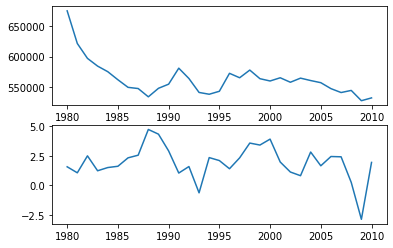

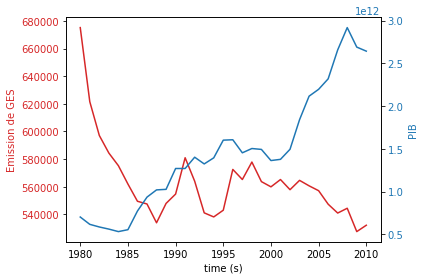

In [19]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

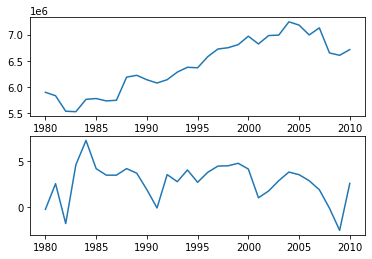

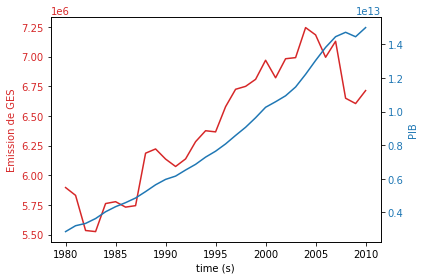

In [20]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Maintenant qu'on à la croissance des émissions de gazs à effet de serre par an, on peut représenter la croissance du PIB et celle-ci sur le même graphe :

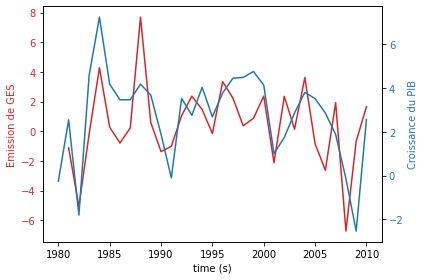

In [23]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_croissance émissions GES (pourcent)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

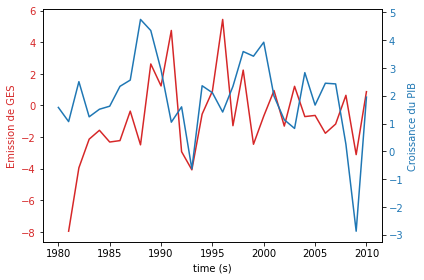

In [24]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_croissance émissions GES (pourcent)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On peut voir qu'il y a apparemment une certaine concommitance des courbes, cela-dit il faut faire attention aux effets d'échelles car ici le PIB ne passe presque jamais dans le négatif (ce qui est loin d'être le cas de la croissance des émissions de gaz à effet de serre). On va essayer de le faire dans le cas de la France pour se faire plus d'idées :

### Suppression des colonnes et lignes inutiles

On a ici la liste des colonnes que l'on supprimme pour se restreindre aux données qui nous intéressent, sutrement dit à partir de 1980 (je ne sais plsu si on avait dit 1980 ou 1985).

In [9]:
useless_data_list = ['Unnamed: 65', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 
                   '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '2020']
df = df.drop(useless_data_list, axis = 1)
#df.sample(15)

On va chercher à enlever les lignes qui ne contiennent que peu d'infos (au moins 10 valeurs manquantes)

In [10]:
df1 = df
nan_dict = {}
for i in range(len(df1.index)) :
    nb_nan = df1.iloc[i].isnull().sum()
    if nb_nan >10 :
        nan_dict[list(df.index)[i]] = nb_nan


df1 = df1.drop(index = nan_dict.keys(), axis = 0)
df1.shape

(2727, 43)

En faisant cela, on supprme environ 600 lignes. Pour le rafiner, il faudrait voir si l'on ne doit pas supprimer toutes les données d'un pays lorsque l'on a que des infos sur deux ou trois indicateurs (notamment qi que sur le PIB). On doit pouvoir s'en sortir en supprimant tous les indexs qui commencent par le code du pays détecté de cette manière.

[Adrien]La fonction pour récupérer les indexs des pays où on a moins de 3 indicateurs.

In [11]:
dic_pays = refresh_dico()

In [12]:
for i in dic_pays.keys() :
    if len(rech_ligne_pays(i,df1))<7 :
        df1 = df1.drop(rech_ligne_pays(i,df1))
dic_pays = refresh_dico()
#ancienne fonction que j'ai écrite plus tot (beaucoup plus lente) :

#for i in nom_pays : 
#    compter_nb_indic = df1.apply(lambda x: True if x['Country Name'] == i else False, axis = 1)
#    if len(compter_nb_indic[compter_nb_indic == True].index) <3 :
#        liste_pays_dic[i] = compter_nb_indic[compter_nb_indic == True].index'''


In [13]:
df1.shape

(2563, 43)

On supprime les lignes des pays dont on a trop peu d'indicateurs complet : (servait pourl'ancienne fonction)

In [14]:
#for i in liste_pays_dic.keys():
#    df1 = df1.drop(index = liste_pays_dic[i], axis = 1)

On a supprimer en tout 58 lignes. De plus on va aussi supprimer de la base les aggrégats de pays (ces lignes là sont colinéaires aux autres, ce qui risque de nous poser problème plus tard dans la prédiction). Voilà les régions à supprimer : Upper middle income, Latin America & the Caribbean (IDA & IBRD countries),Middle East & North Africa (IDA & IBRD countries),South Asia (IDA & IBRD), Middle East & North Africa (IDA & IBRD countries), Latin America & the Caribbean (IDA & IBRD countries),East Asia & Pacific (IDA & IBRD countries), Europe & Central Asia (IDA & IBRD countries), Sub-Saharan Africa, Sub-Saharan Africa (excluding high income), Post-demographic dividend, Pre-demographic dividend, OECD members, North America, Middle East & North Africa (excluding high income), Middle East & North Africa,Late-demographic dividend, Lower middle income
Low & middle income,Latin America & Caribbean,Least developed countries: UN classification, Latin America & Caribbean (excluding high income),IBRD only,IDA & IBRD total,IDA total,IDA blend,Heavily indebted poor countries (HIPC),High income, European Union, Fragile and conflict affected situations,East Asia & Pacific (excluding high income)
Early-demographic dividend, East Asia & Pacific, Europe & Central Asia (excluding high income), Europe & Central Asia,Central Europe and the Baltics


à propos des aggrégats (comment ils aggrègent :)

Aggregation Rules

Aggregates are based on the World Bank’s regional and income classification of economies. Because of missing data, aggregates for groups of economies should be treated as approximations of unknown totals or average values. Regional and income group aggregates are based on the largest available set of data. The aggregation rules are intended to yield estimates for a consistent set of economies from one period to the next and for all indicators. Small differences between sums of subgroup aggregates and overall totals and averages may occur because of the approximations used. In addition, compilation errors and data reporting practices may cause discrepancies in theoretically identical aggregates such as world exports and world imports.

Five methods of aggregation are used in the World Development Indicators:

For group and world totals denoted in the tables by a t, missing data are imputed based on the relationship of the sum of available data to the total in the year of the previous estimate. The imputation process works forward and backward from 2010. Missing values in 2010 are imputed using one of several proxy variables for which complete data are available in that year. The imputed value is calculated so that it (or its proxy) bears the same relationship to the total of available data. Imputed values are usually not calculated if missing data account for more than a third of the total in the benchmark year. The variables used as proxies are GNI in U.S. dollars, total population, exports and imports of goods and services in U.S. dollars, and value added in agriculture, industry, manufacturing, and services in U.S. dollars.

Aggregates marked by an s are sums of available data. Missing values are not imputed. Sums are not computed if more than a third of the observations in the series or a proxy for the series are missing in a given year.

Aggregates of ratios are generally calculated as weighted averages of the ratios (indicated by w) using the value of the denominator or, in some cases, another indicator as a weight. The aggregate ratios are based on available data, including data for economies not shown in the main tables. Missing values are assumed to have the same average value as the available data. No aggregate is calculated if missing data account for more than a third of the value of weights in the benchmark year. In a few cases the aggregate ratio may be computed as the ratio of group totals after imputing values for missing data according to the above rules for computing totals.

Aggregate growth rates are generally calculated as a weighted average of growth rates (and indicated by a w). In a few cases growth rates may be computed from time series of group totals. Growth rates are not calculated if more than half the observations in a period are missing. For further discussion of methods of computing growth rates see below.

Aggregates denoted by an m are medians of the values shown in the table. No value is shown if more than half the observations for countries with a population of more than 1 million are missing. Exceptions to the rules occur throughout the book. Depending on the judgment of World Bank analysts, the aggregates may be based on as little as 50 percent of the available data.
In other cases, where missing or excluded values are judged to be small or irrelevant, aggregates are based only on the data shown in the tables.

Du coup en fonction de comment ils ont agrégés les données ça peut être intéressant ou non de les conserver. Notamment ceux pour lesquels ils ont utilisés la 1ère méthode puisqu'elle nous permet d'avoir une approximation des données qui nous manque (après est ce qu'on veut garder des approximations ? Dans tous les cas il faudra voir je pense si nos prédictions sont robustes à leur ajout ou non)

In [15]:
#/!\ il ne faut faire tourner qu'une seule fois cette fonction, sinon on a une KeyError


suppr_liste = ['Arab World', 'Le monde arabe', 'Central Europe and the Baltics', 'Europe centrale et les pays baltes',
 'Caribbean small states', 'Petits états des Caraïbes','East Asia & Pacific (excluding high income)', 
 'Asie de l’Est et Pacifique (hors revenu élevé)', 'Early-demographic dividend', 
 'de dividende précoce démographique', 'East Asia & Pacific', 'Asie de l’Est et Pacifique',
 'Europe & Central Asia (excluding high income)', 'Europe et Asie centrale (hors revenu élevé)',
 'Europe & Central Asia', 'Europe et Asie centrale',  'Euro area', 'Zone euro', 
 'European Union', 'Union européenne','Fragile and conflict affected situations',
 'Fragile et les situations de conflit touchées', 'High income',
 'Revenu élevé','Heavily indebted poor countries (HIPC)','Pays pauvres très endettés (PPTE)','IBRD only',
 'BIRD seulement','IDA & IBRD total',
 'BIRD et IDA',
 'IDA total',
 'IDA totale',
 'IDA blend',
 'IDA mélange','IDA only',
 'IDA seulement','Latin America & Caribbean (excluding high income)',
 'Amérique latine et Caraïbes (hors revenu élevé)','Latin America & Caribbean',
 'Amérique latine et Caraïbes',
 'Least developed countries: UN classification',
 'Pays les moins avancés\xa0: classement de l’ONU',
 'Low income',
 'Faible revenu','Lower middle income',
 'Revenu intermédiaire, tranche inférieure',
 'Low & middle income',
 'Revenu faible et intermédiaire','Late-demographic dividend',
 'de dividende tardif démographique','Middle East & North Africa',
 'Afrique du Nord et Moyen-Orient','Middle income',
 'Revenu intermédiaire', 'Middle East & North Africa (excluding high income)',
 'Afrique du Nord et Moyen-Orient (hors revenu élevé)','North America',
 'Amérique du Nord','OECD members',
 "Pays membres de l'OCDE",'Other small states',
 'Autres petits états','Pre-demographic dividend',
 'de Pré-dividende démographique', 'Pacific island small states',
 'Petits états insulaires du Pacifique',
 'Post-demographic dividend',
 'de Post-dividende démographique','South Asia',
 'Asie du Sud','Sub-Saharan Africa (excluding high income)',
 'Afrique subsaharienne (hors revenu élevé)',
 'Sub-Saharan Africa',
 'Afrique subsaharienne',
 'Small states',
 'Petits états','East Asia & Pacific (IDA & IBRD countries)',
 'Asie de l’Est et Pacifique (BIRD et IDA)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe et Asie centrale (BIRD et IDA)','Latin America & the Caribbean (IDA & IBRD countries)',
 'Amérique latine et Caraïbes (BIRD et IDA)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Afrique du Nord et Moyen-Orient (BIRD et IDA)', 'South Asia (IDA & IBRD)',
 'Asie du Sud (BIRD et IDA)',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Afrique subsaharienne (BIRD et IDA)','Upper middle income',
 'Revenu intermédiaire, tranche supérieure','World',
 'Monde']

In [16]:
for i in suppr_liste :
    df1 = df1.drop(labels = rech_ligne_pays(i,df1)) 
dic_pays = refresh_dico()
df1.shape

(1974, 43)

In [17]:
data_csv=df1.to_csv('Complete_Data.csv',index=True)

On a supprimer en tout une centaine de lignes encore. On actualise la liste pour stocker uniquement les noms des pays restants :

Idée : on pourrait essayer de faire du clustering afin de déterminer la dépendance de la croissance à certains facteurs afin d'essayer de prédire la dépendance de la croissance à l'émission de gaz à effet de serre.

Je vais essayer de régresser le PIB sur l'émission de gaz à effet de serre dans plusieurs pays : la France, Les Etats Unis, La Chine et le Zimbabwe

## Régressions

### Régressions avec scipy

In [25]:
import scipy.optimize
def affin(x,a,b): 
    return a*x + b

def regress2 (country_code, regresse, regresseur, courbe = False):
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).dropna(axis = 1)
        if interm.shape != (2,0): 

            regresse_val = pd.DataFrame(interm.loc[country_code + regresse][3:30])[country_code + regresse].to_numpy(dtype = float)
            regresseur_val = pd.DataFrame(interm.loc[country_code + regresseur][3:30])[country_code + regresseur].to_numpy(dtype = float)

            popt, pcov = scipy.optimize.curve_fit(affin, regresseur_val, regresse_val)
            coeff, cst = popt[0], popt[1]

            if courbe == True :
                fig, ax1 = plt.subplots()

                color = 'tab:red'
                ax1.set_xlabel('time (s)' + country_code, color = 'k')
                ax1.set_ylabel(regresse, color='k')
                ax1.plot(t[0:31], df1.loc[country_code + regresse][2:42].to_numpy()[1:32].T, color='k')
                ax1.tick_params(axis='y', labelcolor='k')

                ax1.plot(t[0:31], coeff*df1.loc[country_code + regresseur][2:42].to_numpy()[1:32].T + cst, color='b')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                plt.show()

            return coeff, cst
    else : return 
    
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

regresseur = '_GDP (current US$)'
regresse = '_Émissions totales de GES (kt d’équivalent CO2)'
dic = {}

for code in code_list:
    dic[code] = regress2(code, regresse, regresseur, False)
    if dic[code] == None:
        dic.pop(code)
#Attention, il faudra donner un nom explicit à chaque df, différent pour chaque régression.
regress2_df = pd.DataFrame(dic.values(), dic.keys(), ['Coeff', 'Cst'])
regress2_df.head()

,Coeff,Cst
AGO,-1.708738e-07,42796.716066
ALB,-5.227622e-08,8779.637511
ARE,5.916212e-07,45866.834613
ARG,2.627844e-07,242104.529466
ARM,2.204460e-07,9162.633152


### Régressions graphiques avec Seaborn

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics

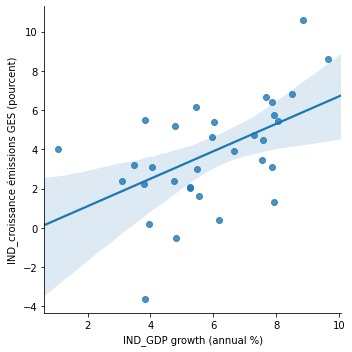

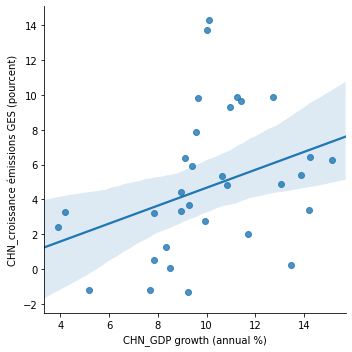

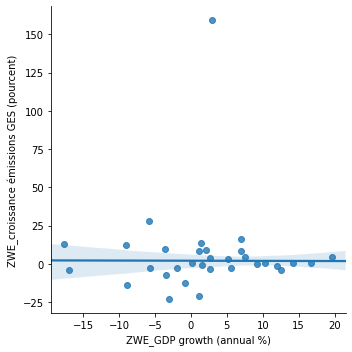

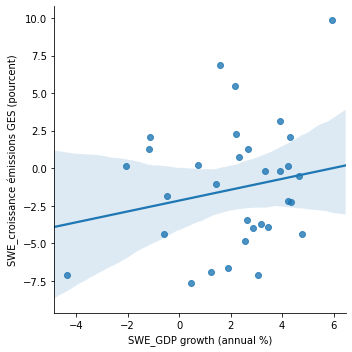

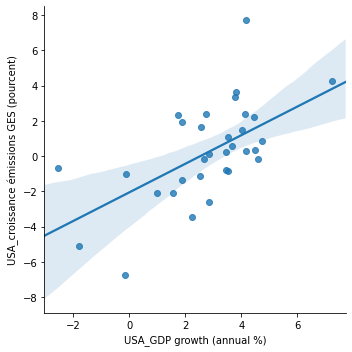

In [27]:

for i in ['IND','CHN','ZWE','SWE','USA']:
    sns.lmplot(x=i+"_GDP growth (annual %)", y=i+"_croissance émissions GES (pourcent)", 
               data=df1.drop(['Country Name','Country Code','Indicator Name'], axis = 1).loc[[i+'_GDP growth (annual %)',i+'_croissance émissions GES (pourcent)']].dropna(axis = 1).T, robust = True)
    
def graph_regress(regresseur,regresse) :
    sns.lmplot(x=regresse, y=regresseur, data=df1.drop(['Country Name',
        'Country Code','Indicator Name'], axis = 1).loc[[regresse,regresseur]].dropna(axis = 1).T, robust = True)

### Régressions avec statsmodels

In [107]:
#On a ici la syntaxe pour faire une régression avec statsmodels, ainsi que la forme de la sortie
x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc['USA_Émissions totales de GES (kt d’équivalent CO2)'].to_numpy())
y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc['USA_GDP (current US$)'].to_numpy()

model = sm.OLS(y,x,'drop')
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     53.28
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           3.25e-08
Time:                        16:11:50   Log-Likelihood:                -988.85
No. Observations:                  33   AIC:                             1982.
Df Residuals:                      31   BIC:                             1985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.343e+13    5.8e+12     -5.762      0.0

In [102]:
interm.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Pays_indic,,,,,,,,,,,,,,,,,,,,,
USA_Émissions totales de GES (kt d’équivalent CO2),5.896083e+06,5.830249e+06,5.534118e+06,5.524778e+06,5.761217e+06,5.776898e+06,5.731026e+06,5.743633e+06,6.185748e+06,6.221392e+06,...,6.991255e+06,7.244272e+06,7.182808e+06,6.994087e+06,7.128952e+06,6.648991e+06,6.604069e+06,6.713349e+06,6.571654e+06,6.343841e+06
"USA_Population, total",2.272250e+08,2.294660e+08,2.316640e+08,2.337920e+08,2.358250e+08,2.379240e+08,2.401330e+08,2.422890e+08,2.444990e+08,2.468190e+08,...,2.901079e+08,2.928053e+08,2.955166e+08,2.983799e+08,3.012312e+08,3.040940e+08,3.067715e+08,3.093217e+08,3.115569e+08,3.138310e+08
USA_GDP (current US$),2.857307e+12,3.207042e+12,3.343789e+12,3.634038e+12,4.037613e+12,4.338979e+12,4.579631e+12,4.855215e+12,5.236438e+12,5.641580e+12,...,1.145824e+13,1.221373e+13,1.303664e+13,1.381461e+13,1.445186e+13,1.471284e+13,1.444893e+13,1.499205e+13,1.554258e+13,1.619701e+13


In [24]:
#On voit ici coment récupérer les coefficients voulus
print(dir(results))
results._get_robustcov_results
results.rsquared

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abat_diagonal', '_cache', '_data_attr', '_data_in_cache', '_get_robustcov_results', '_is_nested', '_use_t', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'diagn', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'initialize', 'k_constant', 'llf', 'load', 'model', 'mse_model', 'mse_resid'

0.6321904749624478

On définit ici la fonction qui permet d'automatiser les régressions sur tous les pays, puis on garde les résultats dans un dataframe.

In [71]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            cst = results.params[0]
            coef = results.params[1]

            return cst, coef, r2
    
    else : return

    
    
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

regresse = '_GDP (current US$)'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'

for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)
        
regress_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante', 'Coefficient', 'R2'])
regress_df.head()

TypeError: unsupported operand type(s) for +: 'float' and 'str'

On peut ensuite effectuer toutes les régressions que l'on souhaite graâce à cette fonction, en changeant simplementles variables regresseur et regresse. Il suffit à chaque fois de créer un dataframe avec un nom différent, de donner des noms plus explicits aux colonnes, et de les concaténer après.

Exemple ci-dessous, en concaténant la régression de gdp sur ges avec celle sur leurs taux de variation

In [82]:
regresse = '_GDP (current US$)'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'


for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)
        
regress1_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante GDP sur total GES',
                                                     'Coefficient GDP sur total GES', 'R2 GDP sur total GES'])
regress1_df.head()




regresse = 'PIB_test'
regresseur = 'Emission GES test'

dic = {}
for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)

regress2_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante GDP_var sur GES_var', 'Coefficient GDP_var sur GES_var', 'R2 GDP_var sur GES_var'])

regress_df = pd.concat([regress1_df, regress2_df], axis = 1)
regress_df.loc['USA']

Constante GDP sur total GES        5.568862e+06
Coefficient GDP sur total GES      9.601371e-08
R2 GDP sur total GES               6.321905e-01
Constante GDP_var sur GES_var      5.568862e+05
Coefficient GDP_var sur GES_var    9.601371e-08
R2 GDP_var sur GES_var             6.321905e-01
Name: USA, dtype: float64

In [ ]:
regress_df.plot(x='Coefficient GDP sur total GES', y='Coefficient GDP_var sur GES_var', kind = 'scatter', label = "Ce graphique n'est pas extraordinaire")

In [79]:
for i in code_list :
    df.loc[i+'PIB_test'] = df.loc[i+'_GDP (current US$)'][4:].astype(np.float64)/10
    df.loc[i+'Emission GES test'] = df.loc[i+'_Émissions totales de GES (kt d’équivalent CO2)'][4:].astype(np.float64)/10
#df1.loc[['ARE_Emission de GES par Tete','ARE_Émissions totales de GES (kt d’équivalent CO2)','ARE_Population, total']]   
    

In [67]:
df.loc[['USAPIB_test','USAEmission GES test']]

,Country Name,Country Code,Indicator Name,1980,1981,1982,1983,1984,1985,1986,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Pays_indic,,,,,,,,,,,,,,,,,,,,,
USAPIB_test,NaN,NaN,NaN,NaN,3.207042e+11,3.343789e+11,3.634038e+11,4.037613e+11,4.338979e+11,4.579631e+11,...,1.499205e+12,1.554258e+12,1.619701e+12,1.678485e+12,1.752175e+12,1.821930e+12,1.870719e+12,1.948539e+12,2.052905e+12,2.137442e+12
USAEmission GES test,NaN,NaN,NaN,NaN,5.830249e+05,5.534118e+05,5.524778e+05,5.761217e+05,5.776898e+05,5.731026e+05,...,6.713349e+05,6.571654e+05,6.343841e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:

regresse = 'PIB_test'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'
x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc['USAEmission GES test'].to_numpy())
y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc['USAPIB_test'].to_numpy()

model = sm.OLS(y,x,'drop')
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.445e+33
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:20:14   Log-Likelihood:                 326.98
No. Observations:                  39   AIC:                            -650.0
Df Residuals:                      37   BIC:                            -646.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   2.05e-05      8.572      0.0